# World Data League 2023

## Notebook Submission Template


## 🎯 Challenge
Determining The Main Mobility Flows in the City of Lisbon Based on Mobile Device Data


## Team: Bayes Bunch
## 👥 Authors
* Samantha Hakes
* Mitra Ganeson
* Zhen-Yen Chan
* Stuart McGibbon
* Roisin Holmes


## 💻 Development


In [ ]:
import pandas as pd
import geopandas as gpd
import json
from matplotlib import pyplot as plt
import numpy as np
import operator
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import LineString, Point
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### define helper functions

In [ ]:
def init_data_assess(df: pd.DataFrame):
    print(df.info(verbose=True))
    print("\n" + "number duplicates: " + str(df.duplicated().sum()))

    return print("initial checks complete")

In [ ]:
def extract_coords_geometry(df: pd.DataFrame) -> pd.DataFrame:
    """create geometry fields from the coordinates of traffic jams"""

    # extract coordinates from 'position' geojson
    df["pos"] = df["position"].apply(
        lambda x: json.loads(x)["geometries"][0]["coordinates"][0]
    )
    # convert to format for spatial field
    df["coords_lst"] = [[tuple(lst_in) for lst_in in lst] for lst in df["pos"]]
    # generate LineString object from coordinate list of tuples
    df["geometry"] = df["coords_lst"].apply(lambda x: LineString(x))

    return df

# 1. Assess Data Quality


datasets required:
1. Mobile device data, source: WDL challenge brief
2. Grid data, source: WDL challenge brief
3. Bus data, source: https://transitfeeds.com/p/carris/1000
4. Waze traffic jam data, source: WDL challenge brief

throughout the challenge, we are interested in November data only (due to changes in Waze data structure). This also helped improve performance by reducing the number of records overall

## 1.1 dataset 1 - mobile device data

In [ ]:
df1_Nov = pd.read_csv(
    "data/lisbon_ficheiros_WDL/ficheiros_WDL/DISPOSITIVOS MOVEIS_GRELHA E EIXOS/CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_11_0001_4000.csv"
)

In [ ]:
# check structure is consistent
print(df1_Nov.head())
print(df1_Nov.tail())

   Grid_ID                  Datetime   C1   C2   C3   C4   C5   C6   C7   C8
0        1  2022-11-09T03:15:00.000Z  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1        1  2022-11-06T08:15:00.000Z  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2        1  2022-11-06T07:00:00.000Z  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3        1  2022-11-06T02:15:00.000Z  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4        1  2022-11-06T13:15:00.000Z  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
          Grid_ID                  Datetime         C1    C2     C3    C4  \
10216646     3743  2022-11-28T00:00:00.000Z  15.230000  0.00  15.23  0.00   
10216647     3743  2022-11-28T01:45:00.000Z  19.059999  0.00  15.95  0.00   
10216648     3743  2022-11-28T03:45:00.000Z   9.890000  0.00   9.89  0.00   
10216649     3743  2022-11-30T05:45:00.000Z  15.440000  5.46  10.45  5.46   
10216650     3743  2022-11-30T01:30:00.000Z   2.880000  0.00   2.88  0.00   

            C5     C6   C7   C8  
10216646  4.28  16.07  0.0  0.0  
1021664

In [ ]:
init_data_assess(df1_Nov)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10216651 entries, 0 to 10216650
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Grid_ID   int64  
 1   Datetime  object 
 2   C1        float64
 3   C2        float64
 4   C3        float64
 5   C4        float64
 6   C5        float64
 7   C6        float64
 8   C7        float64
 9   C8        float64
dtypes: float64(8), int64(1), object(1)
memory usage: 779.5+ MB
None

number duplicates: 0
initial checks complete


- this data has 10 million records, with 10 columns.
- column names are codified (this will need to be changed for clarity)
- columns are mainly floats, the datetime column will need to be converted to datetime
- there are no duplicate rows
- there are no NaN records

## 1.2 dataset2 - grid data

In [ ]:
# read in grid square coordinates (data set 3)
df2 = pd.read_excel(
    "data/lisbon_ficheiros_WDL/ficheiros_WDL/DISPOSITIVOS MOVEIS_QUADRICULAS/DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx"
)

In [ ]:
# check structure is consistent
print(df2.head())
print(df2.tail())

   grelha_id freguesia   latitude  longitude
0          1     Belém  38.692094  -9.225027
1          2     Belém  38.692094  -9.223231
2          3     Belém  38.692094  -9.221434
3          4     Belém  38.692094  -9.219637
4          5     Belém  38.692094  -9.217841
      grelha_id          freguesia   latitude  longitude
3738       3739  Parque das Nações  38.795789  -9.093873
3739       3740  Parque das Nações  38.795789  -9.092077
3740       3741  Parque das Nações  38.797189  -9.097466
3741       3742  Parque das Nações  38.797189  -9.095670
3742       3743  Parque das Nações  38.797189  -9.093873


In [ ]:
init_data_assess(df2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3743 entries, 0 to 3742
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   grelha_id  3743 non-null   int64  
 1   freguesia  3743 non-null   object 
 2   latitude   3743 non-null   float64
 3   longitude  3743 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 117.1+ KB
None

number duplicates: 0
initial checks complete


- this data has 3743 grid cells, each with an area and latitude and longitude.
- some column names are in Portuguese (we will change to English for ease)
- columns are all in appropriate types
- there are no duplicate rows
- there are no NaN records

## 1.3 dataset 3 - bus data

In [ ]:
# read bus datasets - stop time
df3_stop_times = pd.read_csv("data/gtfs/stop_times.txt")

In [ ]:
print(df3_stop_times.head())
print(df3_stop_times.tail())

    trip_id arrival_time departure_time  stop_id  stop_sequence  \
0  28292727     08:00:00       08:00:00    1_801              0   
1  28292727     08:00:20       08:00:20    1_817              1   
2  28292727     08:00:38       08:00:38  1_13824              2   
3  28292727     08:00:48       08:00:48  1_13822              3   
4  28292727     08:01:12       08:01:12  1_13809              4   

   stop_headsign  pickup_type  drop_off_type  shape_dist_traveled  
0            NaN          NaN            NaN                  NaN  
1            NaN          NaN            NaN                  NaN  
2            NaN          NaN            NaN                  NaN  
3            NaN          NaN            NaN                  NaN  
4            NaN          NaN            NaN                  NaN  
         trip_id arrival_time departure_time stop_id  stop_sequence  \
296598  28269988     20:36:19       20:36:19  1_1628             13   
296599  28269988     20:36:44       20:36:44  1

In [ ]:
init_data_assess(df3_stop_times)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296603 entries, 0 to 296602
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              296603 non-null  int64  
 1   arrival_time         296603 non-null  object 
 2   departure_time       296603 non-null  object 
 3   stop_id              296603 non-null  object 
 4   stop_sequence        296603 non-null  int64  
 5   stop_headsign        0 non-null       float64
 6   pickup_type          0 non-null       float64
 7   drop_off_type        0 non-null       float64
 8   shape_dist_traveled  0 non-null       float64
dtypes: float64(4), int64(2), object(3)
memory usage: 20.4+ MB
None

number duplicates: 0
initial checks complete


- this data has 296603 rows,w ith 9 columns
- column names are all good
- arrival time and departure time need to be converted to time
- there are no duplicate rows
- there are 4 columns which all have NaN records, these can be removed

In [ ]:
# read bus datasets - stops
df3_stops = pd.read_csv("data/gtfs/stops.txt")

In [ ]:
print(df3_stops.head())
print(df3_stops.tail())

   stop_id  stop_code        stop_name  stop_desc   stop_lat  stop_lon  \
0   1_7601        NaN        AEROPORTO        NaN  38.767825 -9.128712   
1   1_7602        NaN        AEROPORTO        NaN  38.768962 -9.127978   
2  1_12932        NaN  Agronomia Rugby        NaN  38.717155 -9.190849   
3  1_12901        NaN            AJUDA        NaN  38.709134 -9.199986   
4  1_12902        NaN            AJUDA        NaN  38.709408 -9.199933   

   zone_id  stop_url  location_type  parent_station  
0      NaN       NaN            NaN             NaN  
1      NaN       NaN            NaN             NaN  
2      NaN       NaN            NaN             NaN  
3      NaN       NaN            NaN             NaN  
4      NaN       NaN            NaN             NaN  
     stop_id  stop_code                     stop_name  stop_desc   stop_lat  \
2295  1_8304        NaN                      XABREGAS        NaN  38.728250   
2296  1_8309        NaN                      XABREGAS        NaN  38.7265

In [ ]:
init_data_assess(df3_stops)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   stop_id         2300 non-null   object 
 1   stop_code       0 non-null      float64
 2   stop_name       2300 non-null   object 
 3   stop_desc       0 non-null      float64
 4   stop_lat        2300 non-null   float64
 5   stop_lon        2300 non-null   float64
 6   zone_id         0 non-null      float64
 7   stop_url        0 non-null      float64
 8   location_type   0 non-null      float64
 9   parent_station  0 non-null      float64
dtypes: float64(8), object(2)
memory usage: 179.8+ KB
None

number duplicates: 0
initial checks complete


- this data has 2300 rows, with 10 columns
- column names are all good
- there are no duplicate rows
- there are 6 columns which all have NaN records, these can be removed
- 4 remaining columns have appropriate type

In [ ]:
# read bus datasets - trips
df3_trips = pd.read_csv("data/gtfs/trips.txt")

In [ ]:
print(df3_trips.head())
print(df3_trips.tail())

   route_id  service_id   trip_id  trip_headsign  direction_id  block_id  \
0    193008    28292727  28292727            NaN           NaN       NaN   
1    193008    28292728  28292728            NaN           NaN       NaN   
2    193008    28292729  28292729            NaN           NaN       NaN   
3    193008    28292730  28292730            NaN           NaN       NaN   
4    193008    28292731  28292731            NaN           NaN       NaN   

   shape_id  
0    193008  
1    193008  
2    193008  
3    193008  
4    193008  
       route_id  service_id   trip_id  trip_headsign  direction_id  block_id  \
10233    193573    28270000  28270000            NaN           NaN       NaN   
10234    193573    28270003  28270003            NaN           NaN       NaN   
10235    193573    28270006  28270006            NaN           NaN       NaN   
10236    193573    28269985  28269985            NaN           NaN       NaN   
10237    193573    28269988  28269988            NaN       

In [ ]:
init_data_assess(df3_trips)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10238 entries, 0 to 10237
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   route_id       10238 non-null  int64  
 1   service_id     10238 non-null  int64  
 2   trip_id        10238 non-null  int64  
 3   trip_headsign  0 non-null      float64
 4   direction_id   0 non-null      float64
 5   block_id       0 non-null      float64
 6   shape_id       10238 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 560.0 KB
None

number duplicates: 0
initial checks complete


- this data has 10238 rows, with 7 columns
- column names are all good
- there are no duplicate rows
- there are 3 columns which all have NaN records, these can be removed
- 4 remaining columns have appropriate type

## 1.4 dataset 4 - Waze Data

In [ ]:
# read in traffic congestion (data set 7, file 1)
df4_Nov_1 = gpd.read_file(
    "data/lisbon_ficheiros_WDL/ficheiros_WDL/Waze_QUEBRA DE SERIE/Nov2022/CML_waze_jams_112022_1.csv"
)
print("1st November dataset ingested")

# read in traffic congestion (data set 7, file 2)
df4_Nov_2 = gpd.read_file(
    "data/lisbon_ficheiros_WDL/ficheiros_WDL/Waze_QUEBRA DE SERIE/Nov2022/CML_waze_jams_112022_2.csv"
)
print("2nd November dataset ingested")

# read in traffic congestion (data set 7, file 3)
df4_Nov_3 = gpd.read_file(
    "data/lisbon_ficheiros_WDL/ficheiros_WDL/Waze_QUEBRA DE SERIE/Nov2022/CML_waze_jams_112022_3.csv"
)
print("3rd November dataset ingested")

1st November dataset ingested
2nd November dataset ingested
3rd November dataset ingested


In [ ]:
init_data_assess(df4_Nov_1)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 607534 entries, 0 to 607533
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   entity_ts  607534 non-null  object  
 1   entity_id  607534 non-null  object  
 2   street     607534 non-null  object  
 3   position   607534 non-null  object  
 4   level      607534 non-null  object  
 5   length     607534 non-null  object  
 6   delay      607534 non-null  object  
 7   speed      607534 non-null  object  
 8   geometry   0 non-null       geometry
dtypes: geometry(1), object(8)
memory usage: 41.7+ MB
None

number duplicates: 0
initial checks complete


In [ ]:
(df4_Nov_1["position"].values == "").sum()

4

- this data has ~607k rows, with 9 columns.
- column names are good
- entity_ts column needs to be converted to datetime
- there are no duplicate rows
- there is one column with only NAN - these need to be removed 
- there are 4 empty position rows - these need to be removed

In [ ]:
init_data_assess(df4_Nov_2)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 408715 entries, 0 to 408714
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   entity_ts  408715 non-null  object  
 1   entity_id  408715 non-null  object  
 2   street     408715 non-null  object  
 3   position   408715 non-null  object  
 4   level      408715 non-null  object  
 5   length     408715 non-null  object  
 6   delay      408715 non-null  object  
 7   speed      408715 non-null  object  
 8   geometry   0 non-null       geometry
dtypes: geometry(1), object(8)
memory usage: 28.1+ MB
None

number duplicates: 0
initial checks complete


In [ ]:
(df4_Nov_2["position"].values == "").sum()

0

- this data has ~409k rows, with 9 columns.
- column names are good and match above 
- entity_ts column needs to be converted to datetime
- there are no duplicate rows
- there is one column with only NAN - these need to be removed 

In [ ]:
init_data_assess(df4_Nov_3)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 372771 entries, 0 to 372770
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   entity_ts  372771 non-null  object  
 1   entity_id  372771 non-null  object  
 2   street     372771 non-null  object  
 3   position   372771 non-null  object  
 4   level      372771 non-null  object  
 5   length     372771 non-null  object  
 6   delay      372771 non-null  object  
 7   speed      372771 non-null  object  
 8   geometry   0 non-null       geometry
dtypes: geometry(1), object(8)
memory usage: 25.6+ MB
None

number duplicates: 0
initial checks complete


In [ ]:
(df4_Nov_3["position"].values == "").sum()

0

- this data has ~373k rows, with 9 columns.
- column names are good and match above 
- entity_ts column needs to be converted to datetime
- there are no duplicate rows
- there is one column with only NAN - these need to be removed 

# 2 Data Cleaning

## 2.1 Mobile Data


dataset1 needs to have columns renamed and a column needs to be converted to datetime

In [ ]:
# rename columns (from data dictionary)
df1_Nov.rename(
    columns={
        "C1": "dist_terminals",
        "C2": "diff_roaming",
        "C3": "diff_remained",
        "C4": "diff_remained_roaming",
        "C5": "diff_entries",
        "C6": "diff_outputs",
        "C7": "diff_entries_roaming",
        "C8": "diff_outputs_roaming",
    },
    inplace=True,
)

# check rename has worked correctly
df1_Nov.columns

Index(['Grid_ID', 'Datetime', 'dist_terminals', 'diff_roaming',
       'diff_remained', 'diff_remained_roaming', 'diff_entries',
       'diff_outputs', 'diff_entries_roaming', 'diff_outputs_roaming'],
      dtype='object')

In [ ]:
# convert 'datetime' column to datetime
df1_Nov["Datetime"] = pd.to_datetime(df1_Nov["Datetime"])

# check conversion has worked correctly
df1_Nov.dtypes

Grid_ID                                int64
Datetime                 datetime64[ns, UTC]
dist_terminals                       float64
diff_roaming                         float64
diff_remained                        float64
diff_remained_roaming                float64
diff_entries                         float64
diff_outputs                         float64
diff_entries_roaming                 float64
diff_outputs_roaming                 float64
dtype: object

## 2.2 Dataset 2 - Grid Data

dataset2 needs to have columns renamed

In [ ]:
# rename columns to align with our other column names
df2.rename(columns={"grelha_id": "Grid_ID", "freguesia": "area_name"}, inplace=True)

# check rename has worked correctly
df2.columns

Index(['Grid_ID', 'area_name', 'latitude', 'longitude'], dtype='object')

## 2.3 Dataset 3 - Bus Data

dataset3 - bus stop times
bus data needs to have additional columns removed
arrival time and departure time need to be converted to time

In [ ]:
# drop columns
df3_stop_times.drop(
    columns=["stop_headsign", "pickup_type", "drop_off_type", "shape_dist_traveled"],
    inplace=True,
)

# check drop has been completed
df3_stop_times.isna().sum()

trip_id           0
arrival_time      0
departure_time    0
stop_id           0
stop_sequence     0
dtype: int64

In [ ]:
df3_stop_times = df3_stop_times[df3_stop_times["arrival_time"] < "24:00"]
df3_stop_times["arrival_time"] = pd.to_datetime(
    df3_stop_times["arrival_time"], format="%H:%M:%S"
)
df3_stop_times["departure_time"] = pd.to_datetime(
    df3_stop_times["departure_time"], format="%H:%M:%S"
)

df3_stop_times.dtypes

trip_id                    int64
arrival_time      datetime64[ns]
departure_time    datetime64[ns]
stop_id                   object
stop_sequence              int64
dtype: object

dataset3 - bus stops
bus data needs to have additional columns removed

In [ ]:
df3_stops.drop(
    columns=[
        "stop_code",
        "stop_name",
        "stop_desc",
        "zone_id",
        "stop_url",
        "location_type",
        "parent_station",
    ],
    inplace=True,
)

# check drop has been completed
df3_stops.isna().sum()

stop_id     0
stop_lat    0
stop_lon    0
dtype: int64

dataset3 - bus trips
bus data needs to have additional columns removed

In [ ]:
df3_trips.drop(columns=["trip_headsign", "direction_id", "block_id"], inplace=True)

# check drop has been completed
df3_trips.isna().sum()

route_id      0
service_id    0
trip_id       0
shape_id      0
dtype: int64

## 2.4 Dataset 4 - Waze Traffic Data

dataset4 waze traffic data
- add to one dataframe initially
- remove empty position rows
- remove geometry column
- change entity ts to time

In [ ]:
# concat all 3 files together
df4_all_Nov = pd.concat([df4_Nov_1, df4_Nov_2, df4_Nov_3])
df4_all_Nov.reset_index(inplace=True)

# check row numbers
df4_all_Nov.shape

(1389020, 10)

In [ ]:
# remove rows with no positional data
df4_all_Nov["position"].replace("", np.nan, inplace=True)
df4_all_Nov.dropna(subset=["position"], inplace=True)

# check no empty position rows remain
print((df4_all_Nov["position"].values == "").sum())

0


In [ ]:
# drop geometry column (as all NaN)
df4_all_Nov.drop(columns=["geometry"], inplace=True)

# check drop complete
df4_all_Nov.columns

Index(['index', 'entity_ts', 'entity_id', 'street', 'position', 'level',
       'length', 'delay', 'speed'],
      dtype='object')

In [ ]:
# convert entity_ts to time
df4_all_Nov["entity_ts"] = pd.to_datetime(df4_all_Nov["entity_ts"])

# check data types
df4_all_Nov.dtypes

index                      int64
entity_ts    datetime64[ns, UTC]
entity_id                 object
street                    object
position                  object
level                     object
length                    object
delay                     object
speed                     object
dtype: object

# 3 Feature Engineering


dataset2 - need to pad out points to create polygons (for easier geopandas work)

   Grid_ID                                       grid_polygon
0        1  POLYGON ((-9.22440 38.69316, -9.22367 38.69160...
1        2  POLYGON ((-9.22260 38.69316, -9.22188 38.69160...
2        3  POLYGON ((-9.22080 38.69316, -9.22008 38.69160...
3        4  POLYGON ((-9.21901 38.69316, -9.21828 38.69160...
4        5  POLYGON ((-9.21721 38.69316, -9.21649 38.69160...


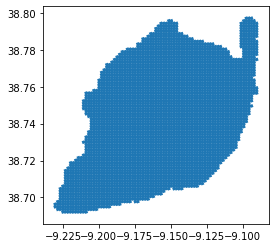

In [ ]:
# create a geometry column from the latitude and longitude values
geometry = [Point(xy) for xy in zip(df2["longitude"], df2["latitude"])]

# pull into geopandas data frame for use in spatial analysis, crs is standard for lat/long
gpd_grid = gpd.GeoDataFrame(df2, crs="epsg:4326", geometry=geometry)

# select subset of data
gdp_grid_cell = gpd_grid[["Grid_ID", "geometry"]]
# reset crs in order to add polygon buffer in metres
gdp_grid_cell = gdp_grid_cell.to_crs("epsg:32634")
# add buffer of 100m to grid centroid points
gdp_grid_cell["grid_polygon"] = gdp_grid_cell["geometry"].buffer(100, cap_style=3)

# return crs to norm for lat/long
gdp_grid_cell = gdp_grid_cell[["Grid_ID", "grid_polygon"]]
gdp_grid_cell = gpd.GeoDataFrame(gdp_grid_cell, geometry="grid_polygon")
gdp_grid_cell = gdp_grid_cell.to_crs("epsg:4326")

# check output is reasonable
print(gdp_grid_cell.head())
gdp_grid_cell.plot()

In [ ]:
# merge back into original grid dataframe
gpd_grid = gpd_grid.merge(
    gdp_grid_cell, how="left", left_on="Grid_ID", right_on="Grid_ID"
)
gpd_grid.drop(columns=["geometry"], inplace=True)
gpd_grid.rename(columns={"grid_polygon": "geometry"}, inplace=True)
gpd_grid.head()

,Grid_ID,area_name,latitude,longitude,geometry
0,1,Belém,38.692094,-9.225027,"POLYGON ((-9.22440 38.69316, -9.22367 38.69160..."
1,2,Belém,38.692094,-9.223231,"POLYGON ((-9.22260 38.69316, -9.22188 38.69160..."
2,3,Belém,38.692094,-9.221434,"POLYGON ((-9.22080 38.69316, -9.22008 38.69160..."
3,4,Belém,38.692094,-9.219637,"POLYGON ((-9.21901 38.69316, -9.21828 38.69160..."
4,5,Belém,38.692094,-9.217841,"POLYGON ((-9.21721 38.69316, -9.21649 38.69160..."


In [ ]:
all_data_grid = df1_Nov.merge(
    gpd_grid[["Grid_ID", "area_name", "latitude", "longitude"]],
    how="left",
    left_on="Grid_ID",
    right_on="Grid_ID",
)

dataset 3  - bus data

In [ ]:
df_bus = df3_trips.merge(
    df3_stop_times, how="left", left_on="trip_id", right_on="trip_id"
)

df_bus = df_bus.merge(df3_stops, how="left", left_on="stop_id", right_on="stop_id")

df_bus["arrival_time_15mins"] = df_bus.arrival_time.dt.round("15min").dt.time

df_bus_rh = df_bus[
    (
        (df_bus.departure_time.dt.strftime("%H:%M") > "07:00")
        & (df_bus.departure_time.dt.strftime("%H:%M") < "10:00")
    )
    | (
        (df_bus.departure_time.dt.strftime("%H:%M") > "17:00")
        & (df_bus.departure_time.dt.strftime("%H:%M") < "18:00")
    )
]

In [ ]:
# create a geometry column from the latitude and longitude values
geometry = [Point(xy) for xy in zip(df_bus_rh["stop_lon"], df_bus_rh["stop_lat"])]

# pull into geopandas data frame for use in spatial analysis
df_bus_rh = gpd.GeoDataFrame(df_bus_rh, crs="epsg:4326", geometry=geometry)

# join bus data with grid data to find grid polygons which overlap with bus stops
bus_grid_cell = gpd.sjoin(left_df=df_bus_rh, right_df=gdp_grid_cell, how="left")

bus_grid_cell.head()

,route_id,service_id,trip_id,shape_id,arrival_time,departure_time,stop_id,stop_sequence,stop_lat,stop_lon,arrival_time_15mins,geometry,index_right,Grid_ID
0,193008,28292727,28292727,193008,1900-01-01 08:00:00,1900-01-01 08:00:00,1_801,0.0,38.715271,-9.136010,08:00:00,POINT (-9.13601 38.71527),745.0,746.0
1,193008,28292727,28292727,193008,1900-01-01 08:00:20,1900-01-01 08:00:20,1_817,1.0,38.716710,-9.135152,08:00:00,POINT (-9.13515 38.71671),745.0,746.0
1,193008,28292727,28292727,193008,1900-01-01 08:00:20,1900-01-01 08:00:20,1_817,1.0,38.716710,-9.135152,08:00:00,POINT (-9.13515 38.71671),803.0,804.0
2,193008,28292727,28292727,193008,1900-01-01 08:00:38,1900-01-01 08:00:38,1_13824,2.0,38.716115,-9.133056,08:00:00,POINT (-9.13306 38.71612),746.0,747.0
3,193008,28292727,28292727,193008,1900-01-01 08:00:48,1900-01-01 08:00:48,1_13822,3.0,38.715464,-9.132090,08:00:00,POINT (-9.13209 38.71546),747.0,748.0


In [ ]:
# find number of stops and routes in each grid cell for each time period
df_bus_rh_agg = (
    bus_grid_cell.groupby(["Grid_ID", "arrival_time_15mins"])
    .agg(
        {
            "route_id": "nunique",
            "service_id": "nunique",
            "trip_id": "nunique",
            "shape_id": "count",
        }
    )
    .reset_index()
)
df_bus_rh_agg.rename(
    columns={
        "route_id": "unique_routes",
        "service_id": "unique_services",
        "trip_id": "unque_trips",
        "shape_id": "buses_stopping",
    },
    inplace=True,
)
df_bus_rh_agg.head()

,Grid_ID,arrival_time_15mins,unique_routes,unique_services,unque_trips,buses_stopping
0,35.0,07:00:00,1,1,1,1
1,35.0,07:15:00,2,4,4,4
2,35.0,07:30:00,2,6,6,6
3,35.0,07:45:00,1,2,2,2
4,35.0,08:00:00,2,4,4,4


dataset 4 waze traffic jams data - find geometry of jam, and map onto grid polygons

In [ ]:
# round date field to 15 minute timeframe
df4_all_Nov["dt_15mins"] = df4_all_Nov["entity_ts"].dt.round("15min")


# generate geometry field
df4_all_Nov = extract_coords_geometry(df4_all_Nov)

In [ ]:
print(len(df4_all_Nov))
df4_all_Nov = gpd.GeoDataFrame(df4_all_Nov, crs="epsg:4326")
# join traffic jam data to grid data to find polygons which jam linestring overlap
df4_all_Nov_grid = gpd.sjoin(left_df=df4_all_Nov, right_df=gdp_grid_cell, how="left")

# expect higher number of rows due to each jam occuring in many cells
print(len(df4_all_Nov_grid))

546627
2424690


In [ ]:
# drop multiple rows per traffic jam (we are keeping the jam at its 'most severe point')
df4_all_Nov_grid = (
    df4_all_Nov_grid.sort_values(["level", "length"], ascending=False)
    .drop_duplicates(["entity_id", "dt_15mins", "Grid_ID"])
    .sort_index()
)
print(len(df4_all_Nov_grid))

945194


In [ ]:
df4_all_Nov_grid["level"] = pd.to_numeric(df4_all_Nov_grid["level"])
df4_all_Nov_grid = df4_all_Nov_grid.groupby(["Grid_ID", "dt_15mins"]).agg(
    number_jams=("entity_id", "count"), average_level=("level", "mean")
)
print(len(df4_all_Nov_grid))

497965


In [ ]:
all_data_grid = all_data_grid.merge(
    df4_all_Nov_grid,
    how="left",
    left_on=["Grid_ID", "Datetime"],
    right_on=["Grid_ID", "dt_15mins"],
)

In [ ]:
# save
all_data_grid.to_parquet("data/all_data_grid")

# 4 Modelling

The modelling approach details the steps taken to select our final model (as well as the dataprep and feature engineering).

In [ ]:

#all_data_grid = pd.read_parquet(Path to Data Prep output), in case these splits need to be split
df = all_data_grid

In [ ]:
# chosen metric
metric = "number_jams"

## 4.1 Feature Engineering

Derive labels and features used for the modelling.

In [ ]:
# metrics derived from jam data
df["jam_score"] = df["number_jams"] * df["average_level"]

# total mobile phone movement (including those remaining)
df["activity"] = (
    df["diff_entries"]
    + df["diff_entries_roaming"]
    + df["diff_outputs"]
    + df["diff_outputs_roaming"]
).fillna(0) + 1
df["weighted_jam_score"] = (df["jam_score"].fillna(0) + 1) / (df["jam_score"]) ** (0.1)


# metrics derived from mobile phone data
df["flow"] = abs(
    df["diff_entries"]
    + df["diff_entries_roaming"]
    + df["diff_outputs"]
    + df["diff_outputs_roaming"]
    - df["diff_remained"]
    - df["diff_remained_roaming"]
)

df = df.fillna(0)

print(df.head())

   Grid_ID                  Datetime  dist_terminals  diff_roaming  \
0      326 2022-11-01 00:00:00+00:00       41.970001     19.870001   
1     2747 2022-11-01 00:00:00+00:00      445.720001     17.629999   
2      965 2022-11-01 00:00:00+00:00      132.059998     42.470001   
3     1876 2022-11-01 00:00:00+00:00       32.139999      0.000000   
4     1095 2022-11-01 00:00:00+00:00      428.450012     26.209999   

   diff_remained  diff_remained_roaming  diff_entries  diff_outputs  \
0      37.000000              14.910000      4.970000     10.620000   
1      69.650002              11.300000    376.079987    324.149994   
2     132.059998              42.470001      5.090000     82.980003   
3      32.139999               0.000000      0.000000     13.410000   
4     425.760010              26.209999     32.549999    156.289993   

   diff_entries_roaming  diff_outputs_roaming  ...  time_of_day  \
0                  4.97                  7.48  ...     00:00:00   
1                 

In [ ]:
# create larger grid point groups (i.e 10 by 10)
lat_labels = [f"lat_{i}" for i in range(1, 11)]
lon_labels = [f"lon_{i}" for i in range(1, 11)]
df["latitude_group"] = pd.cut(df["latitude"], bins=10, labels=lat_labels)
df["longitude_group"] = pd.cut(df["longitude"], bins=10, labels=lon_labels)
df["lat_lon_group"] = (
    df["latitude_group"].astype(str) + "_" + df["longitude_group"].astype(str)
)

df["weekday"] = df.Datetime.dt.weekday
df["hour"] = df.Datetime.dt.hour

df["weekday_sin"] = np.sin(df["weekday"] * (2 * np.pi / 6))
df["weekday_cos"] = np.cos(df["weekday"] * (2 * np.pi / 6))
df["hour_sin"] = np.sin(df["hour"] * (2 * np.pi / 23))
df["hour_cos"] = np.cos(df["hour"] * (2 * np.pi / 23))

In [ ]:
# group by larger grids (lat_lon_group)
df_short = df.groupby(["Datetime", "lat_lon_group"]).agg(
    {
        "unique_routes": "sum",
        "unique_services": "sum",
        "unque_trips": "sum",
        "buses_stopping": "sum",
        "latitude": "mean",
        "longitude": "mean",
        metric: "sum",
        "weekday_sin": "min",
        "weekday_cos": "min",
        "hour_sin": "min",
        "hour_cos": "min",
    }
)

separate out nov 14th (bus data) for later visulisations

In [ ]:
all_data_grid_nov_14 = df[df.Datetime.dt.day == 14]
all_data_grid_nov_14 = all_data_grid_nov_14.sort_values(by="Datetime")
all_data_grid_nov_14["time_of_day"] = all_data_grid_nov_14["Datetime"].dt.time

In [ ]:
# free up some space
df = None

In [ ]:
df_short = df_short.reset_index()
df_short.head()

,Datetime,lat_lon_group,unique_routes,unique_services,unque_trips,buses_stopping,latitude,longitude,number_jams,weekday_sin,weekday_cos,hour_sin,hour_cos
0,2022-11-01 00:00:00+00:00,lat_10_lon_10,6.0,6.0,6.0,6.0,38.791756,-9.095670,0.0,0.866025,0.5,0.0,1.0
1,2022-11-01 00:00:00+00:00,lat_10_lon_5,0.0,0.0,0.0,0.0,38.788632,-9.162145,0.0,0.866025,0.5,0.0,1.0
2,2022-11-01 00:00:00+00:00,lat_10_lon_6,8.0,27.0,27.0,27.0,38.791034,-9.152911,0.0,0.866025,0.5,0.0,1.0
3,2022-11-01 00:00:00+00:00,lat_10_lon_7,2.0,8.0,8.0,8.0,38.789371,-9.144029,0.0,0.866025,0.5,0.0,1.0
4,2022-11-01 00:00:00+00:00,lat_1_lon_1,8.0,21.0,21.0,21.0,38.696936,-9.223027,1.0,0.866025,0.5,0.0,1.0


## 4.2 Data Prep

The aim is train the model at Datetime level. Therefore the data will be aggregated by 15min period. This will mean the features have to unstacked. While this is not optimal, it will allow for basic recurrent neural networks to be trained. More advanced options could involve interpretting the dense geospatial data direcly, perhaps through techniques that are used in image processing.

In [ ]:
flow_agg = df_short.groupby(["Datetime"]).agg(
    {
        metric: "sum",
        "weekday_sin": "min",
        "weekday_cos": "min",
        "hour_sin": "min",
        "hour_cos": "min",
    }
)

df_cut = df_short.copy()[
    [
        "Datetime",
        "unique_routes",
        "unique_services",
        "unque_trips",
        "buses_stopping",
        metric,
        "latitude",
        "longitude",
    ]
]

cc = df_cut.groupby(["Datetime"]).cumcount() + 1
df_u = df_cut.set_index(["Datetime", cc]).unstack().sort_index(1, level=1)

df_u.columns = ["_".join(map(str, i)) for i in df_u.columns]
df_u["score_agg"] = flow_agg[metric]
df_u["weekday_sin"] = flow_agg["weekday_sin"]
df_u["weekday_cos"] = flow_agg["weekday_cos"]
df_u["hour_sin"] = flow_agg["hour_sin"]
df_u["hour_cos"] = flow_agg["hour_cos"]
df_u = df_u.fillna(0)
datetime_col = df_u.index
df_u = df_u.reset_index(drop=True)

<ipython-input-12-2ecf4dfee7a8>:25: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df_u = df_cut.set_index(["Datetime", cc]).unstack().sort_index(1, level=1)


In [ ]:
df_short = None

In [ ]:
latitude_cols = [col for col in df_u.columns if "latitude" in col]
longitude_cols = [col for col in df_u.columns if "longitude" in col]

In [ ]:
# df_u for df unstacked :)
df_u

,buses_stopping_1,latitude_1,longitude_1,number_jams_1,unique_routes_1,unique_services_1,unque_trips_1,buses_stopping_2,latitude_2,longitude_2,...,longitude_78,number_jams_78,unique_routes_78,unique_services_78,unque_trips_78,score_agg,weekday_sin,weekday_cos,hour_sin,hour_cos
0,6.0,38.791756,-9.09567,0.0,6.0,6.0,6.0,0.0,38.788632,-9.162145,...,-9.113799,0.0,0.0,0.0,0.0,532.0,0.866025,0.5,0.000000e+00,1.000000
1,0.0,38.791756,-9.09567,0.0,0.0,0.0,0.0,0.0,38.788632,-9.162145,...,-9.113799,0.0,0.0,0.0,0.0,626.0,0.866025,0.5,0.000000e+00,1.000000
2,0.0,38.791756,-9.09567,0.0,0.0,0.0,0.0,0.0,38.788632,-9.162145,...,-9.113799,0.0,0.0,0.0,0.0,627.0,0.866025,0.5,0.000000e+00,1.000000
3,0.0,38.791756,-9.09567,0.0,0.0,0.0,0.0,0.0,38.788632,-9.162145,...,-9.113799,0.0,0.0,0.0,0.0,566.0,0.866025,0.5,0.000000e+00,1.000000
4,0.0,38.791756,-9.09567,0.0,0.0,0.0,0.0,0.0,38.788632,-9.162145,...,-9.113799,0.0,0.0,0.0,0.0,567.0,0.866025,0.5,2.697968e-01,0.962917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,0.0,38.791756,-9.09567,0.0,0.0,0.0,0.0,0.0,38.788632,-9.162145,...,-9.113799,0.0,3.0,3.0,3.0,306.0,0.866025,-0.5,-2.697968e-01,0.962917
2728,0.0,38.791756,-9.09567,0.0,0.0,0.0,0.0,0.0,38.788632,-9.162145,...,-9.113799,0.0,4.0,6.0,6.0,373.0,0.866025,-0.5,-2.449294e-16,1.000000
2729,28.0,38.791756,-9.09567,0.0,7.0,28.0,28.0,0.0,38.788632,-9.162145,...,-9.113799,0.0,3.0,3.0,3.0,369.0,0.866025,-0.5,-2.449294e-16,1.000000
2730,0.0,38.791756,-9.09567,0.0,0.0,0.0,0.0,0.0,38.788632,-9.162145,...,-9.113799,0.0,9.0,26.0,26.0,324.0,0.866025,-0.5,-2.449294e-16,1.000000


## 4.3 Create Class for windowing Data

In order to train timeseries, the sequential data needs to be windowed into multiple input and predict(shift) sections for both the features and labels. The below classes contains methods for managing this process as well as helpers for plotting results.

The basis of this class comes from the super helpful TensorFlow guide on time series forecasting -> https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model

In [ ]:
class WindowGenerator:
    def __init__(
        self, input_width, label_width, shift, train_df, test_df, label_columns=None
    ):
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=64,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    def example(self, test=False):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            if test is False:
                # No example batch was found, so get one from the `.train` dataset
                result = next(iter(self.train))
                # And cache it for next time
                self._example = result
            elif test:
                # No example batch was found, so get one from the `.train` dataset
                result = next(iter(self.test))
                # And cache it for next time
                self._example = result
        return result

    def plot(self, model=None, plot_col="score_agg", max_subplots=3):
        inputs, labels = self.example()
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k",
                label="Labels",
                c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

            plt.xlabel("time_steps")

    def plot_test(self, model=None, plot_col="score_agg", max_subplots=3):
        inputs, labels = self.example(test=True)
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k",
                label="Labels",
                c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

            plt.xlabel("time_steps")

In [ ]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(window.train, epochs=MAX_EPOCHS)
    return history

In [ ]:
# track performance results
performance = {}

In [ ]:
# set window sizes
IN_WIDTH = 96
OUT_STEPS = 96

## 4.4 Predict a single Label

We have two options for the label format

- One figure to represent the traffic level (or equivelent) in all of lisbon
- Multiple Labels for each defined grid box

The former is more straightforward to predict and the data is less sparse. However the later will likely be of more use to the model's user.

### 4.4.1 Benchmark: Persistant Last

The first model isn't really a model at all! We'll set a very simple benchmark for the deep learning approaches to beat by simply predicting all future values to be the same as the last value in the trainset.

In [ ]:
df_u_features = df_u[
    ["score_agg", "weekday_sin", "weekday_cos", "hour_sin", "hour_cos"]
]

n = len(df_u)
train_df = df_u_features[0 : int(n * 0.8)]
test_df = df_u_features[int(n * 0.8) :]
train_mean = train_df.mean()
train_std = train_df.std()

#scaling both features and labels
train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
column_indices = {name: i for i, name in enumerate(df_u_features.columns)}

In [ ]:
#
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

In [ ]:
bench_pl_window = WindowGenerator(
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    test_df=test_df,
)

In [ ]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [ ]:
performance["Baseline_Last"] = last_baseline.evaluate(bench_pl_window.test, verbose=0)
performance["Baseline_Last"]
# loss (MSE), metric (MAE)

[1.271469235420227, 0.7600797414779663]

Testing predictions from the train set

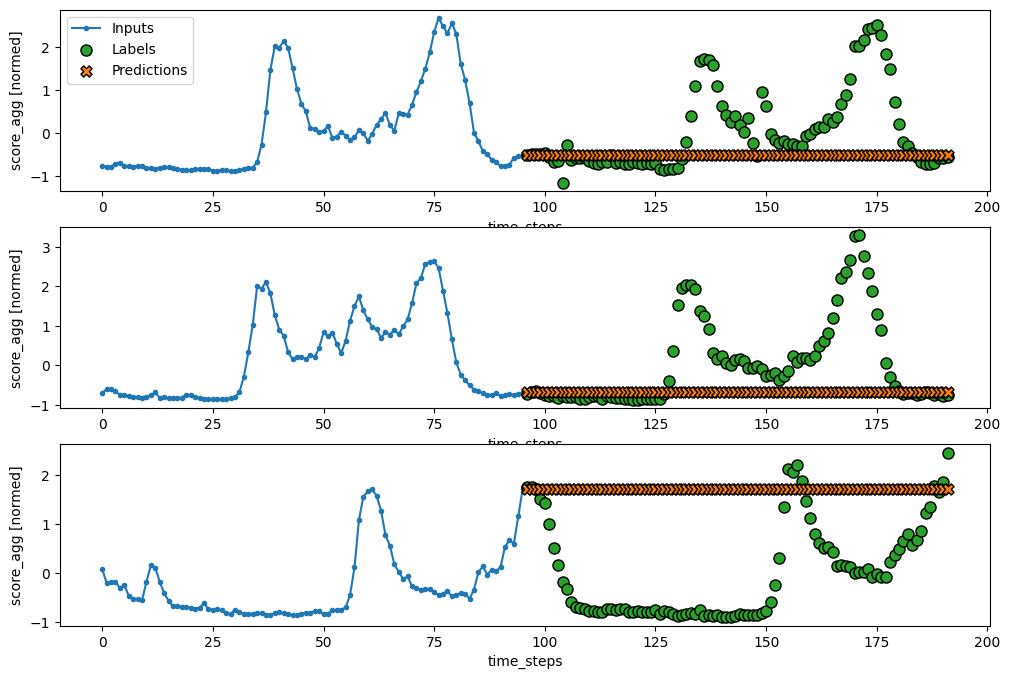

In [ ]:
bench_pl_window.plot(last_baseline)

Testing predictions from the test set

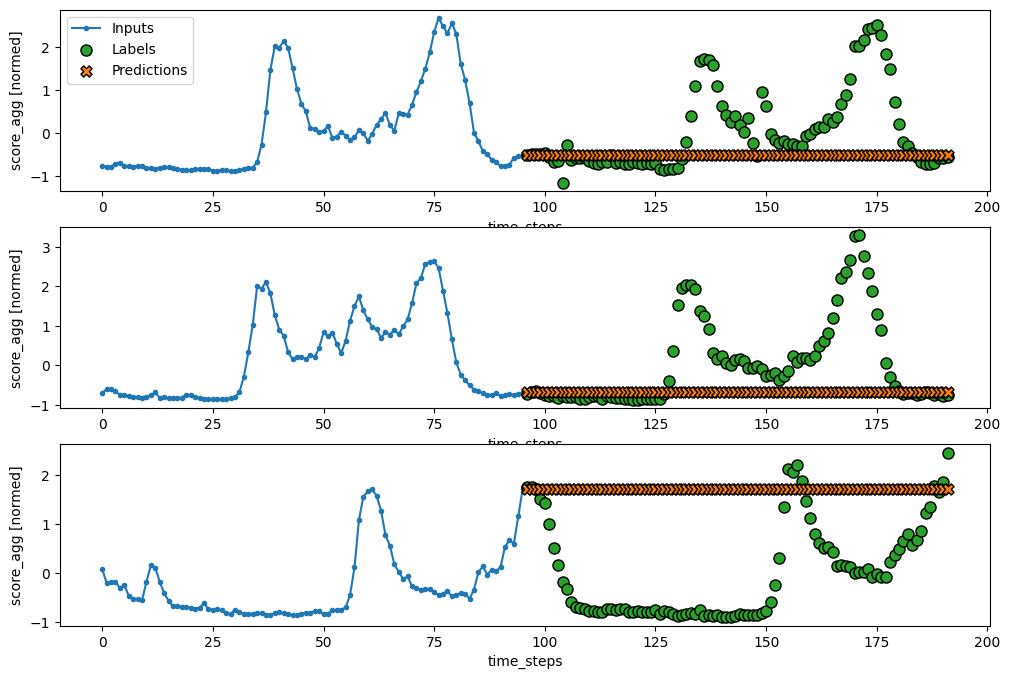

In [ ]:
bench_pl_window.plot_test(last_baseline)

### 4.4.2 Benchmark: Repeat Baseline

Another baseline we could use is the previous cycle repeated again. This could be more informative than the previous baseline as the traffic data has beenshown to vary depending on the time of day.

In [ ]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

In [ ]:
bench_r_window = WindowGenerator(
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    test_df=test_df,
)

In [ ]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [ ]:
performance["Baseline_Repeat"] = repeat_baseline.evaluate(
    bench_r_window.test, verbose=0
)
performance["Baseline_Repeat"]
# loss (MSE), metric (MAE)

[0.417033851146698, 0.34783729910850525]

Testing predictions from the train set

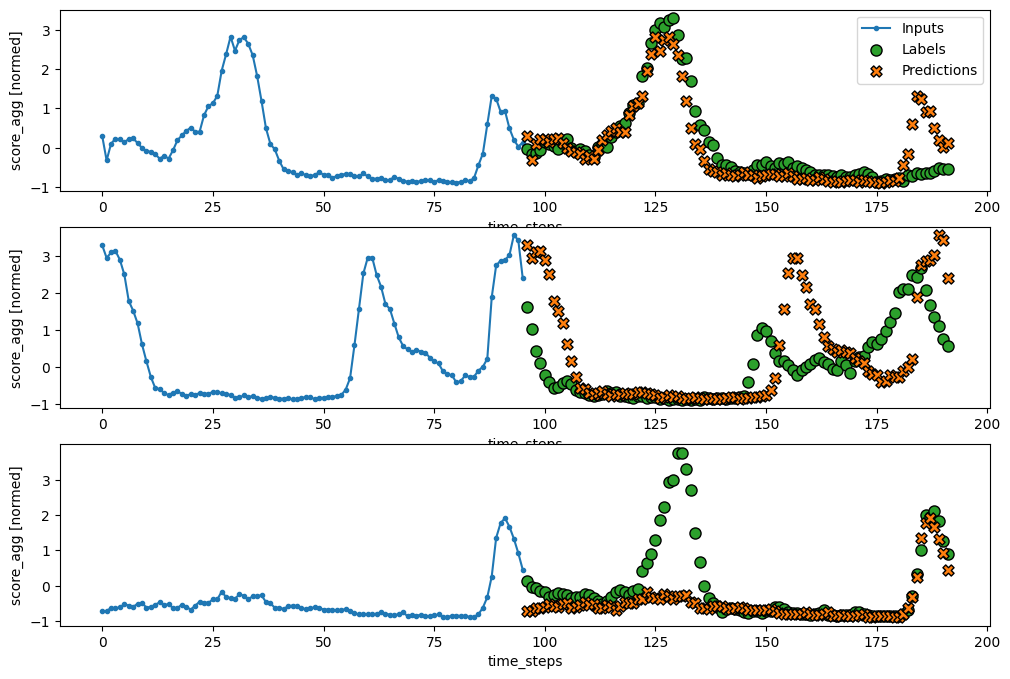

In [ ]:
bench_r_window.plot(repeat_baseline)

Testing predictions from the test set

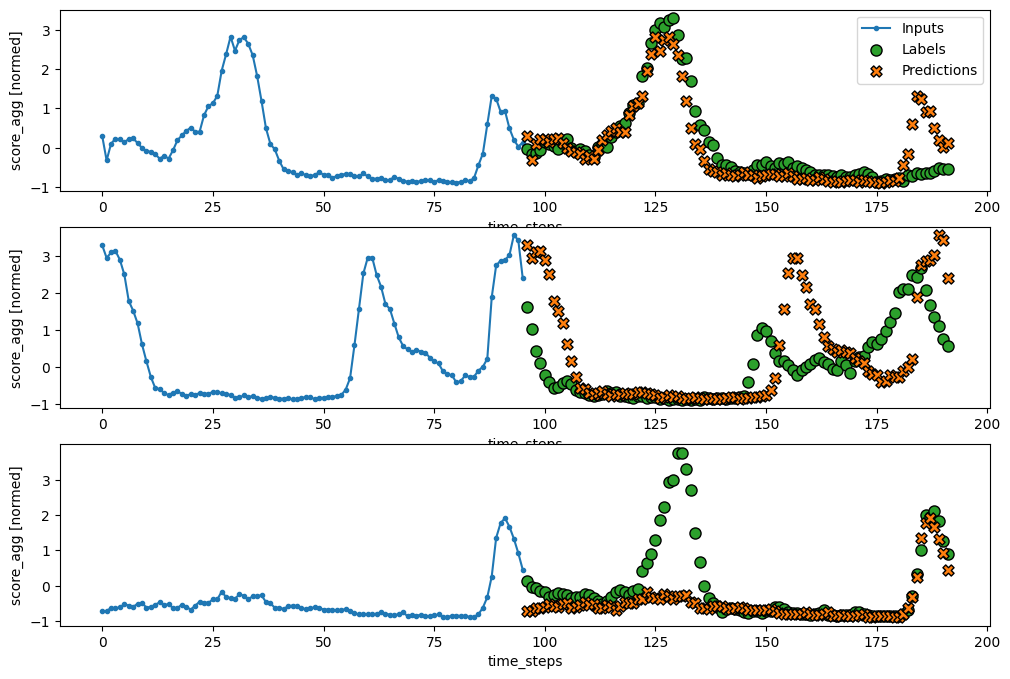

In [ ]:
bench_r_window.plot_test(repeat_baseline)

**Comment**: It can be seen that this is often a reasonable approcimation

### 4.4.3 Neural Networks with only the label and time features

A simple approach can be to to forecast only the label and determine if any underlying pattern can be established. In addition to the label, basic cyclical time features are derived from the Datetime at each step

In [ ]:
df_u_features = df_u[
    ["score_agg", "weekday_sin", "weekday_cos", "hour_sin", "hour_cos"]
]

n = len(df_u)
train_df = df_u_features[0 : int(n * 0.8)]
test_df = df_u_features[int(n * 0.8) :]
train_mean = train_df.mean()
train_std = train_df.std()

#scaling both features and labels
train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
w1 = WindowGenerator(
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    test_df=test_df,
    label_columns=["score_agg"],
)

In [ ]:
# check shape of inputs
for example_inputs, example_labels in w1.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (64, 96, 5)
Labels shape (batch, time, features): (64, 96, 1)


#### 4.4.3.1 LSTM Layers

In [ ]:
multi_lstm_model = tf.keras.Sequential(
    [
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(
            OUT_STEPS * train_df.shape[0], kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[0]]),
    ]
)

In [ ]:
history = compile_and_fit(multi_lstm_model, w1)

Epoch 1/20
32/32 [==============================] - 9s 15ms/step - loss: 1.0187 - mean_absolute_error: 0.7534
Epoch 2/20
32/32 [==============================] - 0s 14ms/step - loss: 0.8830 - mean_absolute_error: 0.6840
Epoch 3/20
32/32 [==============================] - 0s 14ms/step - loss: 0.7525 - mean_absolute_error: 0.6071
Epoch 4/20
32/32 [==============================] - 0s 13ms/step - loss: 0.6836 - mean_absolute_error: 0.5679
Epoch 5/20
32/32 [==============================] - 0s 13ms/step - loss: 0.6219 - mean_absolute_error: 0.5430
Epoch 6/20
32/32 [==============================] - 0s 14ms/step - loss: 0.5686 - mean_absolute_error: 0.5175
Epoch 7/20
32/32 [==============================] - 0s 14ms/step - loss: 0.5209 - mean_absolute_error: 0.4924
Epoch 8/20
32/32 [==============================] - 0s 13ms/step - loss: 0.4753 - mean_absolute_error: 0.4683
Epoch 9/20
32/32 [==============================] - 0s 13ms/step - loss: 0.4325 - mean_absolute_error: 0.4447
Epoch 10/2

In [ ]:
performance["No_Bus_LSTM"] = multi_lstm_model.evaluate(w1.test, verbose=0)
performance["No_Bus_LSTM"]
# loss MSE, metric MAE

[0.24080774188041687, 0.31447720527648926]

Testing predictions from the train set

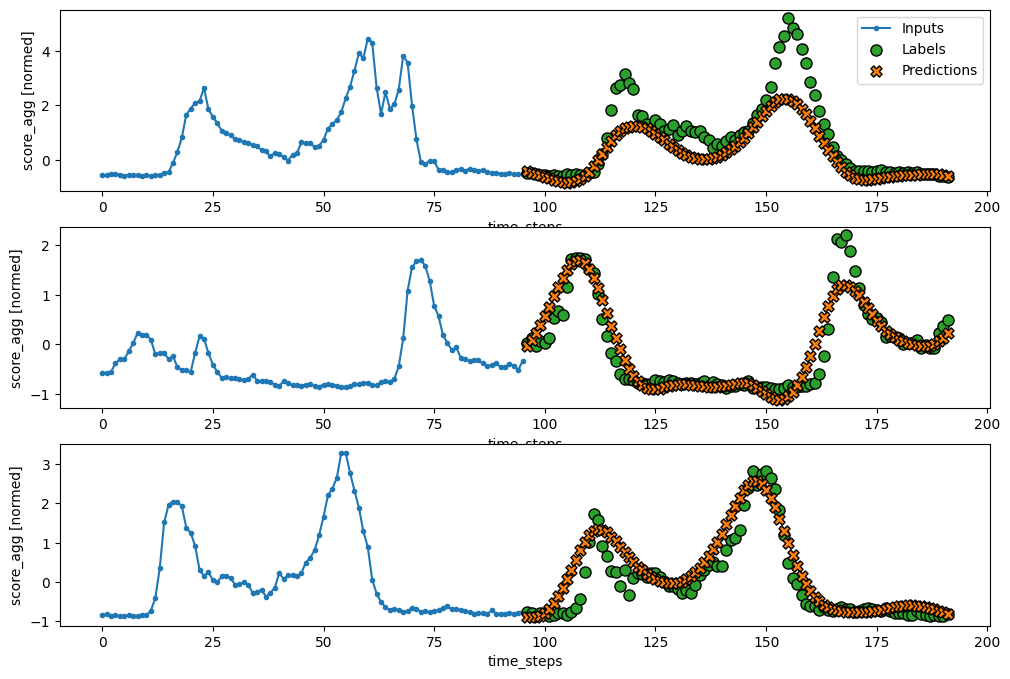

In [ ]:
w1.plot(multi_lstm_model)

Testing predictions from the train set

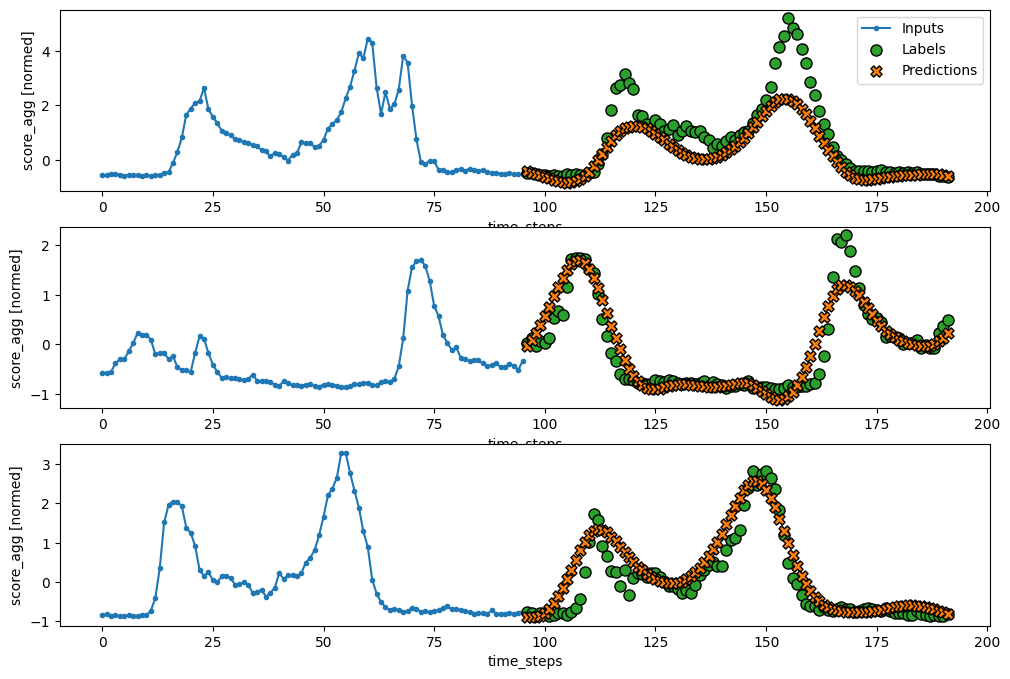

In [ ]:
w1.plot_test(multi_lstm_model)

#### 4.4.3.2 Dense Layers

In [ ]:
multi_dense_model = tf.keras.Sequential(
    [
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(512, activation="relu"),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * train_df.shape[0], kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[0]]),
    ]
)

In [ ]:
history = compile_and_fit(multi_dense_model, w1)

Epoch 1/20
32/32 [==============================] - 2s 35ms/step - loss: 0.9804 - mean_absolute_error: 0.7368
Epoch 2/20
32/32 [==============================] - 1s 34ms/step - loss: 0.7412 - mean_absolute_error: 0.6154
Epoch 3/20
32/32 [==============================] - 1s 36ms/step - loss: 0.6285 - mean_absolute_error: 0.5425
Epoch 4/20
32/32 [==============================] - 1s 37ms/step - loss: 0.5915 - mean_absolute_error: 0.5255
Epoch 5/20
32/32 [==============================] - 1s 33ms/step - loss: 0.5664 - mean_absolute_error: 0.5169
Epoch 6/20
32/32 [==============================] - 1s 33ms/step - loss: 0.5469 - mean_absolute_error: 0.5109
Epoch 7/20
32/32 [==============================] - 1s 33ms/step - loss: 0.5315 - mean_absolute_error: 0.5064
Epoch 8/20
32/32 [==============================] - 1s 33ms/step - loss: 0.5193 - mean_absolute_error: 0.5052
Epoch 9/20
32/32 [==============================] - 1s 33ms/step - loss: 0.5092 - mean_absolute_error: 0.5005
Epoch 10/2

In [ ]:
performance["No_Bus_Dense"] = multi_dense_model.evaluate(w1.test, verbose=0)
performance["No_Bus_Dense"]
# loss MSE, metric MAE

[0.4260917901992798, 0.4267157018184662]

Testing predictions from the train set

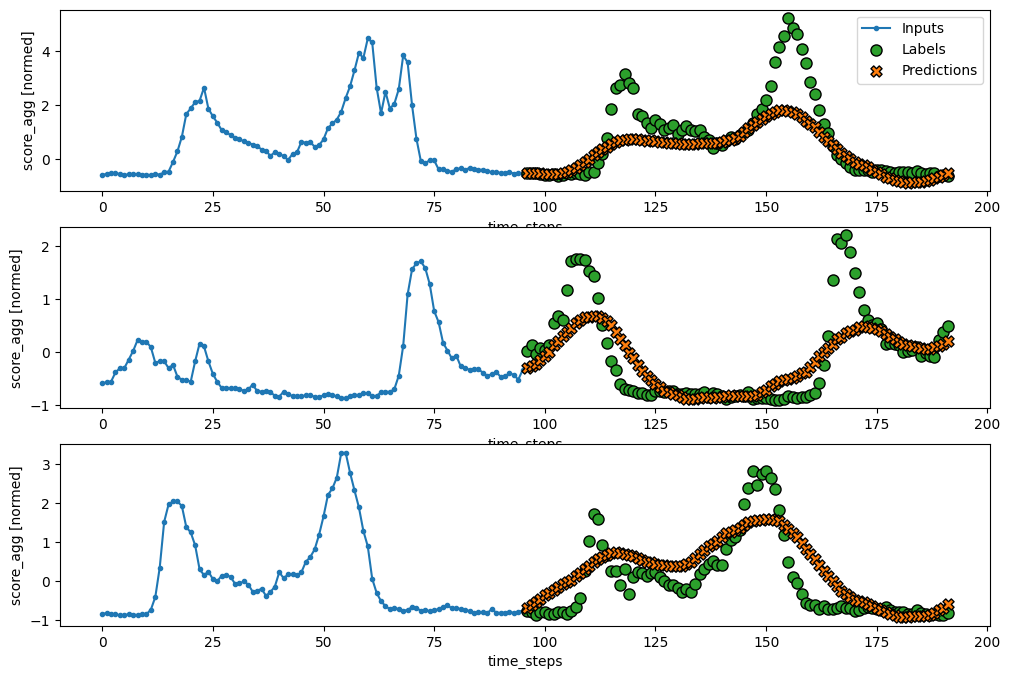

In [ ]:
w1.plot(multi_dense_model)

Testing predictions from the test set

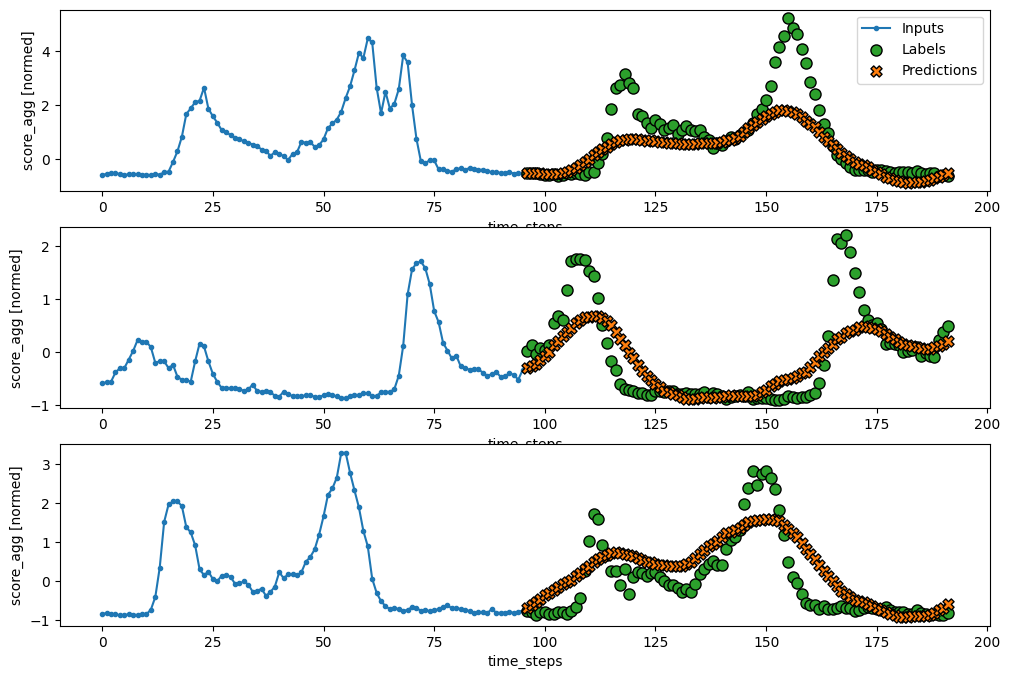

In [ ]:
w1.plot_test(multi_dense_model)

### 4.4.4 Train with bus data

Additional features related to bus activity in each grid was introduced to determine if this aided predictions.

In [ ]:
df_u_features_bus = df_u.copy()
df_u_features_bus = df_u_features_bus.fillna(0)

In [ ]:
df_u_features_bus.drop(columns=latitude_cols, inplace=True)
df_u_features_bus.drop(columns=longitude_cols, inplace=True)

In [ ]:
df_u_features_bus

,buses_stopping_1,number_jams_1,unique_routes_1,unique_services_1,unque_trips_1,buses_stopping_2,number_jams_2,unique_routes_2,unique_services_2,unque_trips_2,...,buses_stopping_78,number_jams_78,unique_routes_78,unique_services_78,unque_trips_78,score_agg,weekday_sin,weekday_cos,hour_sin,hour_cos
0,6.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,532.0,0.866025,0.5,0.000000e+00,1.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,626.0,0.866025,0.5,0.000000e+00,1.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,627.0,0.866025,0.5,0.000000e+00,1.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,566.0,0.866025,0.5,0.000000e+00,1.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,567.0,0.866025,0.5,2.697968e-01,0.962917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,3.0,3.0,3.0,306.0,0.866025,-0.5,-2.697968e-01,0.962917
2728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,4.0,6.0,6.0,373.0,0.866025,-0.5,-2.449294e-16,1.000000
2729,28.0,0.0,7.0,28.0,28.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,3.0,3.0,3.0,369.0,0.866025,-0.5,-2.449294e-16,1.000000
2730,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,26.0,0.0,9.0,26.0,26.0,324.0,0.866025,-0.5,-2.449294e-16,1.000000


In [ ]:
n = len(df_u)
train_df = df_u_features_bus[0 : int(n * 0.8)]
test_df = df_u_features_bus[int(n * 0.8) :]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

#scaling both features and labels
train_df = ((train_df - train_mean) / train_std).fillna(0)
test_df = ((test_df - train_mean) / train_std).fillna(0)

In [ ]:
w2 = WindowGenerator(
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    test_df=test_df,
    label_columns=["score_agg"],
)

w2

Total window size: 192
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): ['score_agg']

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (64, 96, 395)
Labels shape (batch, time, features): (64, 96, 1)


#### 4.4.4.1 LSTM Layers

In [ ]:
multi_lstm_model = tf.keras.Sequential(
    [
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(
            OUT_STEPS * train_df.shape[0], kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[0]]),
    ]
)

In [ ]:
history = compile_and_fit(multi_lstm_model, w2)

Epoch 1/20
32/32 [==============================] - 6s 24ms/step - loss: 0.9837 - mean_absolute_error: 0.7358
Epoch 2/20
32/32 [==============================] - 1s 23ms/step - loss: 0.8496 - mean_absolute_error: 0.6630
Epoch 3/20
32/32 [==============================] - 1s 22ms/step - loss: 0.7520 - mean_absolute_error: 0.6152
Epoch 4/20
32/32 [==============================] - 1s 23ms/step - loss: 0.6572 - mean_absolute_error: 0.5646
Epoch 5/20
32/32 [==============================] - 1s 22ms/step - loss: 0.5695 - mean_absolute_error: 0.5169
Epoch 6/20
32/32 [==============================] - 1s 21ms/step - loss: 0.4947 - mean_absolute_error: 0.4765
Epoch 7/20
32/32 [==============================] - 1s 22ms/step - loss: 0.4317 - mean_absolute_error: 0.4421
Epoch 8/20
32/32 [==============================] - 1s 21ms/step - loss: 0.3812 - mean_absolute_error: 0.4145
Epoch 9/20
32/32 [==============================] - 1s 22ms/step - loss: 0.3424 - mean_absolute_error: 0.3930
Epoch 10/2

In [ ]:
performance["Bus_LSTM"] = multi_lstm_model.evaluate(w2.test, verbose=0)
performance["Bus_LSTM"]
# loss (MSE, metric (MAE))

[0.29891902208328247, 0.3666788637638092]

Plotting predictions from the train set

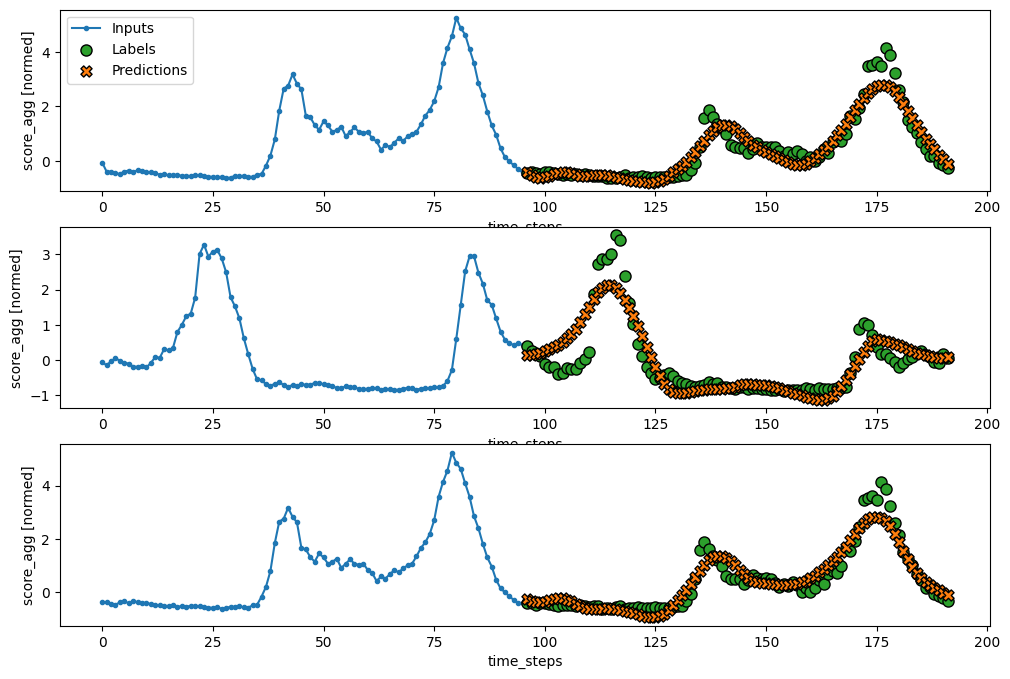

In [ ]:
w2.plot(multi_lstm_model)

Plotting predictions from test set

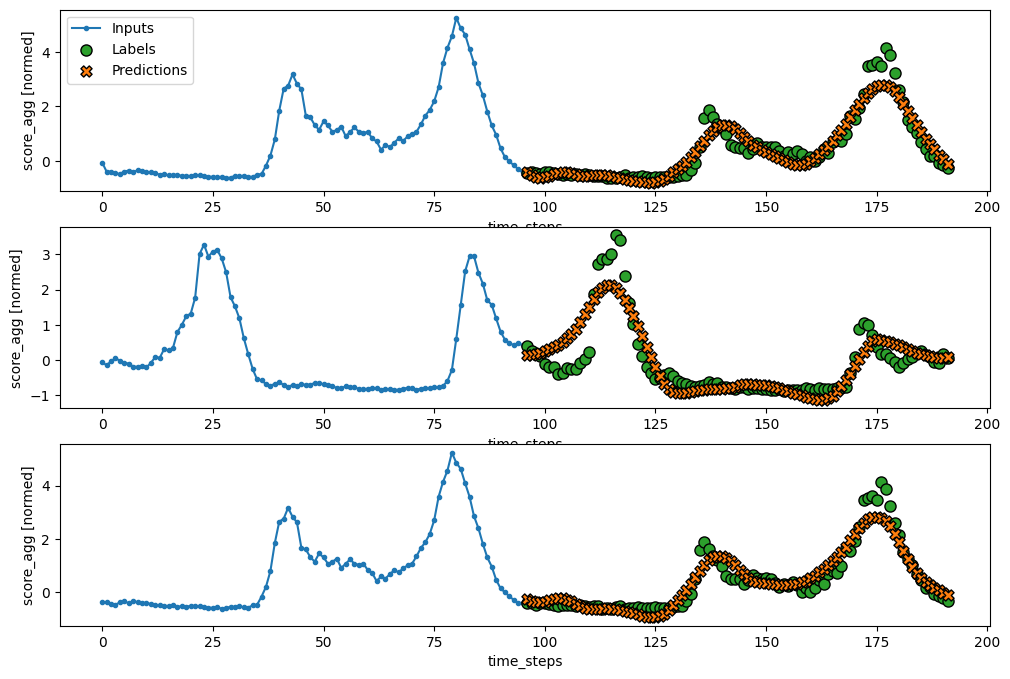

In [ ]:
w2.plot_test(multi_lstm_model)

#### 4.4.4.2 Dense Layers


In [ ]:
multi_dense_model = tf.keras.Sequential(
    [
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(512, activation="relu"),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * train_df.shape[0], kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[0]]),
    ]
)

In [ ]:
history = compile_and_fit(multi_dense_model, w2)

Epoch 1/20
32/32 [==============================] - 3s 48ms/step - loss: 0.7938 - mean_absolute_error: 0.6448
Epoch 2/20
32/32 [==============================] - 2s 46ms/step - loss: 0.5225 - mean_absolute_error: 0.5054
Epoch 3/20
32/32 [==============================] - 1s 38ms/step - loss: 0.3993 - mean_absolute_error: 0.4329
Epoch 4/20
32/32 [==============================] - 1s 38ms/step - loss: 0.3532 - mean_absolute_error: 0.4059
Epoch 5/20
32/32 [==============================] - 1s 38ms/step - loss: 0.3201 - mean_absolute_error: 0.3856
Epoch 6/20
32/32 [==============================] - 1s 38ms/step - loss: 0.2974 - mean_absolute_error: 0.3689
Epoch 7/20
32/32 [==============================] - 1s 38ms/step - loss: 0.2794 - mean_absolute_error: 0.3573
Epoch 8/20
32/32 [==============================] - 1s 39ms/step - loss: 0.2753 - mean_absolute_error: 0.3528
Epoch 9/20
32/32 [==============================] - 2s 44ms/step - loss: 0.2564 - mean_absolute_error: 0.3380
Epoch 10/2

In [ ]:
performance["Bus_Dense"] = multi_dense_model.evaluate(w2.test, verbose=0)
performance["Bus_Dense"]
# loss (MSE), metric (MAE)

[0.29167672991752625, 0.3645371198654175]

Plot predictions from train set

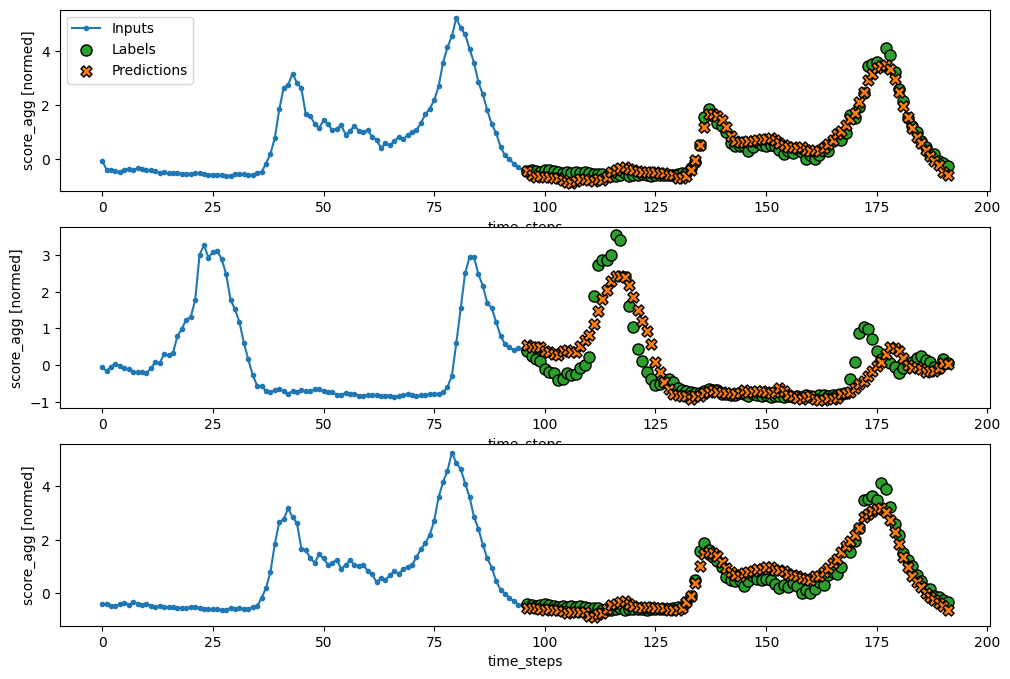

In [ ]:
w2.plot(multi_dense_model)

Plot predictions from test set

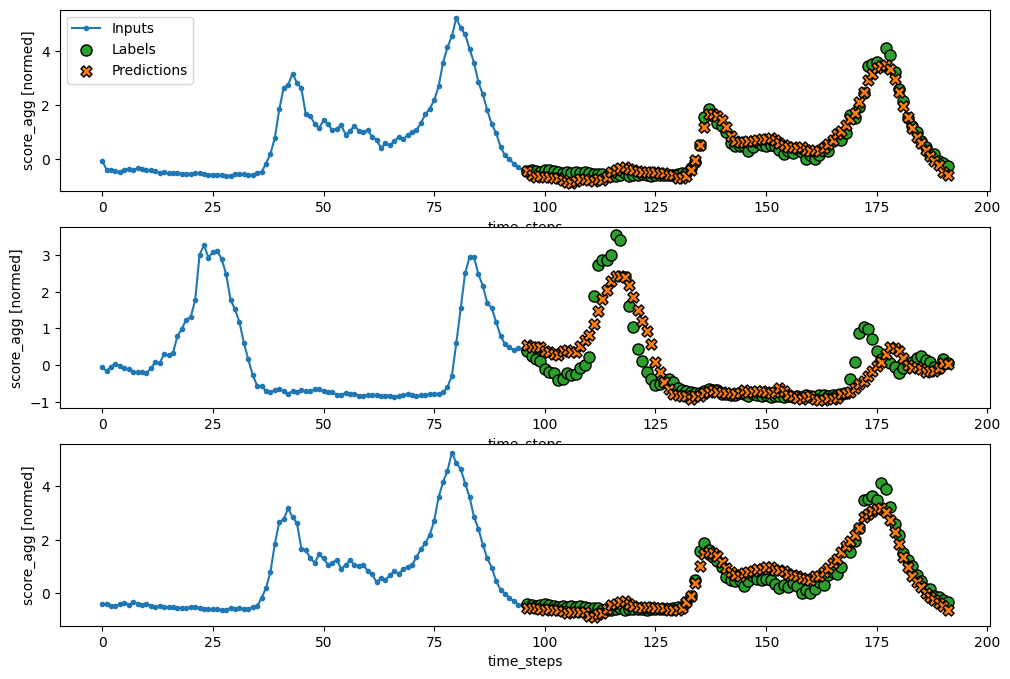

In [ ]:
w2.plot_test(multi_dense_model)

### 4.4.5 Compare Results

In [ ]:
performance
# loss (MSE), metric (MAE)

{'Baseline_Last': [1.271469235420227, 0.7600797414779663],
 'Baseline_Repeat': [0.417033851146698, 0.34783729910850525],
 'No_Bus_LSTM': [0.24080774188041687, 0.31447720527648926],
 'No_Bus_Dense': [0.4260917901992798, 0.4267157018184662],
 'Bus_LSTM': [0.29891902208328247, 0.3666788637638092],
 'Bus_Dense': [0.29167672991752625, 0.3645371198654175]}

**Conclusion** It is clear from both the results and sample plots that the number of jams (the metric in this case) can be approximated to a reasonable level. However, only the LSTM model with no bus data (4.4.3.1) clear out performed the baseline model.

## 4.5 Predict multiple labels

As mentioned in the previous section, the ultimate aim was to predict a metric accross multiple grid cells.

While the output from this did not end up being useful, we've included it as this approach best represents where we see this model (and tool) going in the future.

In [ ]:
# prep data
df_u_features_bus = df_u.copy().drop(columns=["score_agg"])
df_u_features_bus.drop(columns=latitude_cols, inplace=True)
df_u_features_bus.drop(columns=longitude_cols, inplace=True)

labels = [label for label in df_u_features_bus.columns if metric in label]
n = len(df_u)
train_df = df_u_features_bus[0 : int(n * 0.8)]
test_df = df_u_features_bus[int(n * 0.8) :]
train_mean = train_df.mean()
train_std = train_df.std()

#scaling both features and labels
train_df = ((train_df - train_mean) / train_std).fillna(0)
test_df = ((test_df - train_mean) / train_std).fillna(0)

train_df.shape

(2185, 394)

In [ ]:
w3 = WindowGenerator(
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    test_df=test_df,
    label_columns=labels,
)

In [ ]:
lstm_model = tf.keras.models.Sequential(
    [
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(50, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=78),
    ]
)

In [ ]:
history = compile_and_fit(lstm_model, w3)

Epoch 1/20
32/32 [==============================] - 5s 28ms/step - loss: 0.8711 - mean_absolute_error: 0.5671
Epoch 2/20
32/32 [==============================] - 1s 26ms/step - loss: 0.6838 - mean_absolute_error: 0.4728
Epoch 3/20
32/32 [==============================] - 1s 27ms/step - loss: 0.5815 - mean_absolute_error: 0.4228
Epoch 4/20
32/32 [==============================] - 1s 26ms/step - loss: 0.5302 - mean_absolute_error: 0.3996
Epoch 5/20
32/32 [==============================] - 1s 26ms/step - loss: 0.4963 - mean_absolute_error: 0.3834
Epoch 6/20
32/32 [==============================] - 1s 26ms/step - loss: 0.4707 - mean_absolute_error: 0.3723
Epoch 7/20
32/32 [==============================] - 1s 25ms/step - loss: 0.4501 - mean_absolute_error: 0.3636
Epoch 8/20
32/32 [==============================] - 1s 27ms/step - loss: 0.4325 - mean_absolute_error: 0.3565
Epoch 9/20
32/32 [==============================] - 1s 26ms/step - loss: 0.4173 - mean_absolute_error: 0.3504
Epoch 10/2

In [ ]:
performance["LSMT_bus_multilabel"] = lstm_model.evaluate(w3.test, verbose=0)

In [ ]:
predictions = lstm_model.predict(w3.test)

6/6 [==============================] - 1s 19ms/step


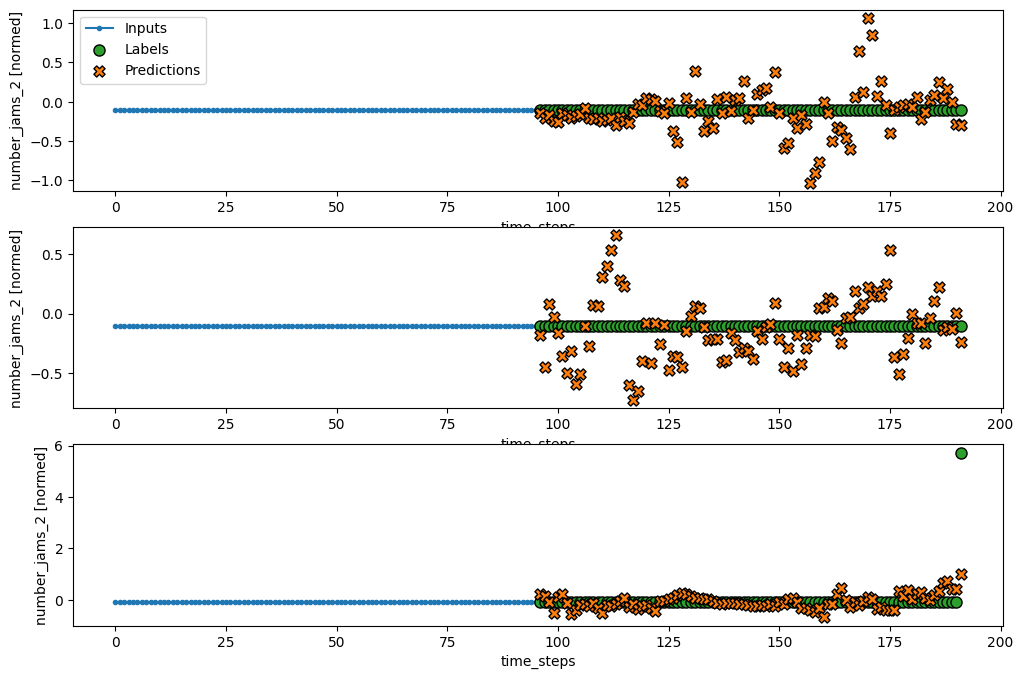

In [ ]:
w3.plot(lstm_model, plot_col=metric + "_2")

### 4.5.1 Predict For Next Day (For 10 x 10 Grid)

The predictions plots are less useful than for the single label. Therefore the predictions will be visulized in a 10 by 10 grid.

In [ ]:
preds = pd.DataFrame(predictions[0, :, :], columns=labels)

In [ ]:
loc_df = df_u[latitude_cols + longitude_cols].iloc[: preds.shape[0]]

In [ ]:
results_df = pd.DataFrame(columns=["score", "latitude", "longitude", "time_step"])
for index, row in preds.iterrows():
    results_snapshot = pd.DataFrame(
        columns=["score", "latitude", "longitude", "time_step"]
    )
    results_snapshot["score"] = preds.iloc[index].T.values
    results_snapshot["latitude"] = loc_df[latitude_cols].iloc[0].T.values
    results_snapshot["longitude"] = loc_df[longitude_cols].iloc[0].T.values
    results_snapshot["time_step"] = index
    results_df = pd.concat([results_df, results_snapshot], ignore_index=True)

results_df["score"] = results_df["score"] + abs(results_df["score"].min())

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter_mapbox(
    results_df,
    lat="latitude",
    lon="longitude",
    animation_frame="time_step",
    size="score",
    opacity=0.5,
)
fig.update_layout(title="World map", title_x=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

**Conclusion** It's clear (just from the locations of the large score values) that the model has not genelrized well to the test set. This may be down to the lack of data in some grid cells and the imbalance towards more populated areas.

## 🖼️ Visualisations

To better represent our data, we've used plotly to vary the plots with time (hence they are not static).

We've focused on visulations that demonstrate how traffic base metrics change over time.

To view a snapshot of these plots please see the links beside each plot.

## Vis 1: Number of Jams in each 200x200m grid cell

link to static image -> https://github.com/StuartJMc/wdl_bayes_bunch_resources/blob/main/vis1_number_jams.png

In [ ]:
fig = px.scatter_mapbox(
    all_data_grid_nov_14,
    lat="latitude",
    lon="longitude",
    animation_frame="Datetime",
    size="number_jams",
    opacity=0.5,
)
fig.update_layout(title="World map", title_x=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## Vis 2: 'Flow' in each 200x200m grid cell

Flow is derived from the mobile data by:

```{python}
df["flow"] = abs(
    df["diff_entries"]
    + df["diff_entries_roaming"]
    + df["diff_outputs"]
    + df["diff_outputs_roaming"]
    - df["diff_remained"]
    - df["diff_remained_roaming"]
)
```

For a static image please see -> https://github.com/StuartJMc/wdl_bayes_bunch_resources/blob/main/vis2_flow.png

In [ ]:
fig = px.scatter_mapbox(
    all_data_grid_nov_14,
    lat="latitude",
    lon="longitude",
    animation_frame="Datetime",
    size="flow",
    opacity=0.5,
)
fig.update_layout(title="World map", title_x=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## Vis 3: Weighted Jam Score in each 200mx200m grid

Jam score is defined as:



```
# metrics derived from jam data
df["jam_score"] = df["number_jams"] * df["average_level"]

# total mobile phone movement (including those remaining)
df["activity"] = (
    df["diff_entries"]
    + df["diff_entries_roaming"]
    + df["diff_outputs"]
    + df["diff_outputs_roaming"]
).fillna(0) + 1


df["weighted_jam_score"] = (df["jam_score"].fillna(0) + 1) / (df["jam_score"]) ** (0.1)
```

For a static image please see -> https://github.com/StuartJMc/wdl_bayes_bunch_resources/blob/main/vis3_weight_jam_score.png

In [ ]:
fig = px.scatter_mapbox(
    all_data_grid_nov_14,
    lat="latitude",
    lon="longitude",
    animation_frame="Datetime",
    size="weighted_jam_score",
    opacity=0.5,
)
fig.update_layout(title="World map", title_x=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## Vis 4 Number of Traffic Jams in Lisbon over time:

Text(0, 0.5, 'Number of Jams')

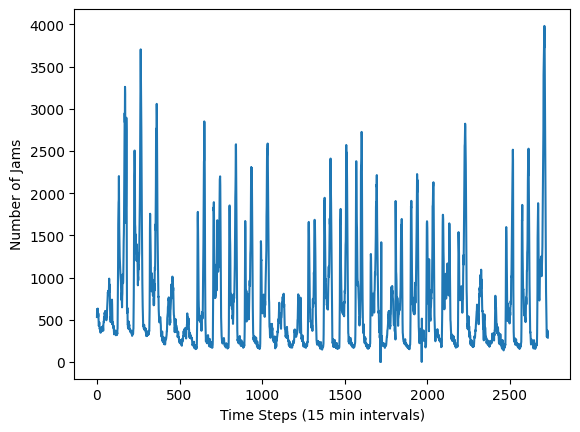

In [ ]:
df_u['score_agg'].plot()
plt.xlabel('Time Steps (15 min intervals)')
plt.ylabel('Number of Jams')

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

 - WDL data all from https://wdl-data.fra1.digitaloceanspaces.com/lisbon%2Fficheiros_WDL.zip
 - Carris bus data from https://transitfeeds.com/p/carris/1000
 - Tensorflow Time-Series Tutorial - https://www.tensorflow.org/tutorials/structured_data/time_series#single-shot_models